# Experiment 2: Pandas Dataframes as data structures for Graphs

[//]: # (------------------------------------------    DO NOT MODIFY THIS    ------------------------------------------)
<style type="text/css">
.tg  {border-collapse:collapse;
      border-spacing:0;
     }
.tg td{border-color:black;
       border-style:solid;
       border-width:1px;
       font-family:Arial, sans-serif;
       font-size:14px;
       overflow:hidden;
       padding:10px 5px;
       word-break:normal;
      }
.tg th{border-color:black;
       border-style:solid;
       border-width:1px;
       font-family:Arial, sans-serif;
       font-size:14px;
       font-weight:normal;
       overflow:hidden;
       padding:10px 5px;
       word-break:normal;
      }
.tg .tg-fymr{border-color:inherit;
             font-weight:bold;
             text-align:left;
             vertical-align:top
            }
.tg .tg-0pky{border-color:inherit;
             text-align:left;
             vertical-align:top
            }
[//]: # (--------------------------------------------------------------------------------------------------------------)

[//]: # (-------------------------------------    FILL THIS OUT WITH YOUR DATA    -------------------------------------)
</style>
<table class="tg">
    <tbody>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Title:</td>
        <td class="tg-0pky">Experiment 3: Pandas Dataframes as data structures for Graphs</td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Authors:</td>
        <td class="tg-0pky">
            <a href="https://github.com/ecarrenolozano" target="_blank" rel="noopener noreferrer">Edwin Carreño</a>
        </td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Affiliations:</td>
        <td class="tg-0pky">
            <a href="https://www.ssc.uni-heidelberg.de/en" target="_blank" rel="noopener noreferrer">Scientific Software Center</a>
        </td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Date Created:</td>
        <td class="tg-0pky">30.10.2024</td>
      </tr>
      <tr>
        <td class="tg-fymr" style="font-weight: bold">Description:</td>
        <td class="tg-0pky">Creation of a graph using Pandas dataframes and data from CSV files. Conversion to NetworkX is tested too.</td>
      </tr>
    </tbody>
</table>

[//]: # (--------------------------------------------------------------------------------------------------------------)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

In this notebook we are going to:

1. Import CSV (comma-separated values) data from nodes and edges.
2. Describe the data from CSVs.
3. Create a data pipeline that:
   - load CSV data as Pandas dataframes.
4. Create a NetworkX graph from a Pandas dataframes.

## Setup (if required)

The following function checks if a library of interest is installed. Depending on the parameter `install`, you can install it automatically.

In [1]:
import subprocess
from importlib.metadata import version
from importlib.util import find_spec

def check_package_install(package, install=False):
    if find_spec(package) is None:
        print(package,"is NOT installed in Python environment")
        if install:
            try:
                subprocess.check_call(["python", "-m", "pip", "install", package])
            except subprocess.CalledProcessError as e:
                print(f"\tError occurred: {e}")
                print(f"\tCheck the name of your package!")
            print(package, "has been installed with version: ", version(package))
    else:
        print(package,"is installed with version: ", version(package))

### NetworkX installation

In [2]:
check_package_install("networkx", install=False)

networkx is installed with version:  3.4.2


### Pandas installation

In [3]:
check_package_install("pandas", install=False)

pandas is installed with version:  2.2.2


## Importing Libraries

In [4]:
"""
Recommendations:
    - Respect the order of the imports, they are indicated by the numbers 1, 2, 3.
    - One import per line is recommended, with this we can track easily any modified line when we use git.
    - Absolute imports are recommended (see 3. Local application/library specific imports below), they improve readability and give better error messages.
    - You should put a blank line between each group of imports.
"""

# future-imports (for instance: from __future__ import barry_as_FLUFL)
# from __future__ import barry_as_FLUFL  

# 1. Standard library imports
import ast
import csv
import os
from itertools import islice

# 2. Related third party imports
import networkx as nx
import pandas as pd
from IPython.display import Image 

# 3. Local application/library specific imports
# import <mypackage>.<MyClass>         # this is an example
# from <mypackage> import <MyClass>    # this is another example 

## Helper Functions

In [5]:
def load_csv_generator(file_path, header=True):
    with open(file_path, "r") as file:
        reader = csv.reader(file)
        if header:
            next(reader)
        for row in reader:
            yield tuple(row)

def from_csv_to_pandasdf(file_path, delimiter=','):
    return pd.read_csv(file_path,
                       delimiter=delimiter)

def create_dataframes(file_path_nodes, file_path_edges):
    nodes_df = from_csv_to_pandasdf(file_path_nodes, delimiter=',')
    edges_df = from_csv_to_pandasdf(file_path_edges, delimiter=',')
    return nodes_df, edges_df

def row_to_dictionary(df, columns_to_keep_intact):
    if isinstance(columns_to_keep_intact, list):
        remaining_df = df.drop(columns=columns_to_keep_intact, axis=1)
    if isinstance(columns_to_keep_intact, dict):
        remaining_df = df.drop(columns=list(columns_to_keep_intact.keys()), axis=1)
        
    temp_dicts = pd.Series([dict(zip(remaining_df.columns, row)) for row in remaining_df.to_numpy()], name="temp_dicts")

    return pd.concat([df.drop(columns=remaining_df.columns, axis=1), temp_dicts], axis=1)

def merge_properties(df, column_to_keep, column_to_merge):
    
    df[column_to_keep] = df[column_to_keep].map(ast.literal_eval)
    df[column_to_keep] = [{**c1, **c2} for c1, c2 in zip(df[column_to_keep], df[column_to_merge])]
    
    return df.drop(columns=column_to_merge, axis=1)

def change_column_names(df, column_names_dict):
    return df.rename(columns=column_names_dict)


def df_to_networkx_nodes(nodes_df, columns_to_keep_intact, column_names_dict):
    nodes_df_transformed = (nodes_df
                            .pipe(row_to_dictionary, columns_to_keep_intact=columns_to_keep_intact)
                            .pipe(merge_properties, column_to_keep="properties", column_to_merge="temp_dicts")
                            .pipe(change_column_names, column_names_dict)
    )
    return nodes_df_transformed

def df_to_networkx_edges(edges_df, columns_to_keep_intact, column_names_dict):
    edges_df_transformed = (edges_df
                            .pipe(row_to_dictionary, columns_to_keep_intact=columns_to_keep_intact)
                            .pipe(merge_properties, "properties", "temp_dicts")
                            .pipe(change_column_names, column_names_dict)
    )
    return edges_df_transformed


def networkx_graph_from_pandas(networkx_nodes_df, networkx_edges_df, graph_type=nx.DiGraph()):
    # create an empty graph
    networkx_graph = graph_type
    
    # populate_graph_nodes_properties
    networkx_graph.add_edges_from(pd.concat([networkx_edges_df[["source", "target"]],
                                             networkx_edges_df["properties"]#.map(ast.literal_eval)
                                            ],
                                            axis=1).itertuples(index=False, name=None)
                                 )

    # populate_graph_nodes_properties
    networkx_graph.add_nodes_from(pd.concat([networkx_nodes_df["source"],
                                             networkx_nodes_df["properties"]#.map(ast.literal_eval)
                                            ],
                                            axis=1).itertuples(index=False, name=None)
                                 )
    return networkx_graph

## Introduction

A graph is collection of nodes and edges that expresses the relationship between nodes. A minimal node contain their `node label`. Similarly, a minimal edge contain the `source id`, `target id` and `label`.

The data for nodes and edges can be stored in form of tuples. Figure 1 shows the graph that can be constructed with the information from the dataset `dataset_dummy2_edges.csv` and `dataset_dummy2_nodes.csv` 

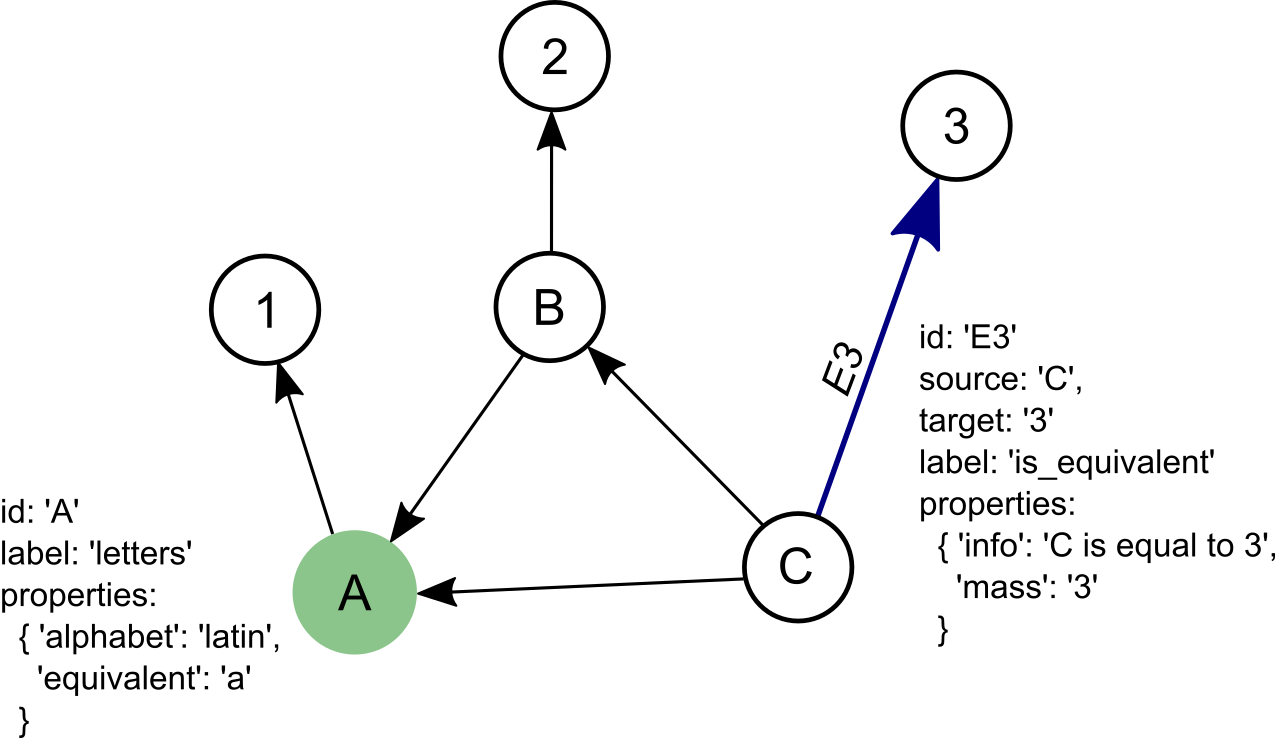

In [6]:
Image(filename="./images/graph_dataset_dummy2.png", width=600, height=600) 

In this notebook we are going to work with a little bit complex graphs (more nodes, and more edges). Additionally, each node and edge contain properties that are from our interest to keep in order to use for subsequent frameworks, i.e. machine learning and optimization frameworks.

## Section 1: Load the CSV data that contains nodes and edges

For this exercise, each graph is represented by two CSV files. One containing information about the **nodes** and the other about the **edges**. To indicate that both files correspond to the same graph, their names include the same number of nodes. For example:

- `dataset_30_nodes_proteins.csv`: contains 30 rows (nodes).
- `dataset_30_edges_interactions.csv`: contains 47 rows (edges).

We reference each CSV file or dataset as follows:

In [7]:
#filename_nodes = "dataset_dummy2_nodes.csv"
#filename_edges = "dataset_dummy2_edges.csv"

filename_nodes = "dataset_30_nodes_proteins.csv"
filename_edges = "dataset_30_edges_interactions.csv"

# FILE_PATH_DATASETS = "../../../DATASETS"
FILE_PATH_DATASETS = "../data_examples"

### 1.1: Load Nodes

The CSV file for nodes contains three columns:
- `UniProt ID`
- `label`
- `properties`

We are going to load the information of nodes as a **list of tuples**. Each tuple represents a node with the structure:
- `(id, label, properties)`
- Each field in the tuple is a `string`
- The `properties` field is a string containing a dictionary of properties.

In [8]:
file_path_nodes = os.path.join(FILE_PATH_DATASETS, filename_nodes)

list_nodes = [node for node in load_csv_generator(file_path_nodes, header=True)]

In [9]:
print("The NODES dataframe contains: {} nodes".format(len(list_nodes)))
print("Example:\n\t{}".format(list_nodes[0]))

The NODES dataframe contains: 30 nodes
Example:
	('G0P1I0', 'uniprot_protein', "{'sequence': 'QKRTLFKVEFGSMSWFYKHRTNMHLRTMMYD', 'description': 'Lorem ipsum ilymp', 'taxon': '7813'}")


### 1.2: Load Edges

The CSV file for edges contains five columns:
- `Relation ID`
- `Source ID`
- `Target ID`
- `label`
- `properties`

We are going to load the information of edges as a list of tuples. Each tuple represents a node with thethe structure:
- `(id, source, target, label, properties)`
- Each field in the tuple is a `string`
- The `properties` field is string containing a dictionary of properties.

In [10]:
file_path_edges = os.path.join(FILE_PATH_DATASETS, filename_edges)

list_edges = [edge for edge in load_csv_generator(file_path_edges, header=True)]

In [11]:
print("The list of EDGES contains: {} edges".format(len(list_edges)))
print("Example:")
for edge in list_edges[0:6]:
    print("\t{}".format(edge))

The list of EDGES contains: 47 edges
Example:
	('', 'B6V6V7', 'H9R6K5', 'interacts_with', "{'source': 'signor'}")
	('', 'B6V6V7', 'I5X3I2', 'interacts_with', "{'method': 'Lorem ipsum pblfc'}")
	('', '385603', 'H9R6K5', 'interacts_with', "{'source': 'intact', 'method': 'Lorem ipsum nbqvj'}")
	('', '385603', 'I9A3P8', 'interacts_with', '{}')
	('', 'L3V2Y6', 'X0C9T5', 'interacts_with', "{'source': 'intact', 'method': 'Lorem ipsum zwhrq'}")
	('intact956331', 'L3V2Y6', 'Y8Y3K0', 'interacts_with', "{'source': 'signor'}")


## Section 2: Create Data Pipeline
- **input:** CSV data of edges
- **output:** Pandas dataframe containing information of edges

The pipeline consist of two consecutive stages:

| Stage | Function                              | Description |
|-------|---------------------------------------| ----------- |
| 1     | `create_dataframes()`           | create  Pandas dataframes for nodes and edges       |
|       | `from_csv_to_pandas()`          | generator to transform a CSV into a pandas dataframe |

### 2.1 Create Pandas Dataframe from CSV file (data structure)

In [12]:
nodes_df, edges_df = create_dataframes(file_path_nodes, file_path_edges)

In [13]:
nodes_df.head(3)

,UniProt ID,label,properties
0,G0P1I0,uniprot_protein,{'sequence': 'QKRTLFKVEFGSMSWFYKHRTNMHLRTMMYD'...
1,B6V6V7,uniprot_isoform,{'sequence': 'CGLGLSMRFLMVGVQNWFWYGTRVPDVAYIDW...
2,385603,entrez_protein,{'sequence': 'EHYTERRSMRSTGQDKTSNPYLFFHITRFKRC...


In [14]:
edges_df.head(3)

,Relationship ID,Source ID,Target ID,label,properties
0,NaN,B6V6V7,H9R6K5,interacts_with,{'source': 'signor'}
1,NaN,B6V6V7,I5X3I2,interacts_with,{'method': 'Lorem ipsum pblfc'}
2,NaN,385603,H9R6K5,interacts_with,"{'source': 'intact', 'method': 'Lorem ipsum nb..."


## Section 3: Converting to Networkx graph
### Create Data Pipeline
- **input:** Pandas dataframes
- **output:** A NetworkX graph

The pipeline consist of two consecutive stages:

| Stage | Function                              | Description |
|-------|---------------------------------------| ----------- |
| 1     | `df_to_networkx_nodes()`       | create  Pandas dataframes for nodes and edges       |
|       | `row_to_dictionary()`          | generator to transform a CSV into a pandas dataframe |
|       | `merge_properties()`           | generator to transform a CSV into a pandas dataframe |
| 1     | `df_to_networkx_edges()`       | create  Pandas dataframes for nodes and edges       |
|       | `row_to_dictionary()`          | generator to transform a CSV into a pandas dataframe |
|       | `merge_properties()`           | generator to transform a CSV into a pandas dataframe |
| 2     | `networkx_graph_from_pandas()` | create  Pandas dataframes for nodes and edges       |
|       | `nx.from_pandas_edgelist()`    | generator to transform a CSV into a pandas dataframe |
|       | `graph.add_nodes_from()`       | generator to transform a CSV into a pandas dataframe |

### 3.1 Create a Directed Graph

In [15]:
# Dictionaries to change the name of columns to maintain compatibility with Networkx
columns_names_nodes={
    "UniProt ID": "source",
    "properties": "properties"    
}


columns_names_edges={
    "Source ID": "source",
    "Target ID": "target",
    "properties": "properties"    
}


G = networkx_graph_from_pandas(networkx_nodes_df=df_to_networkx_nodes(nodes_df,
                                                                      columns_to_keep_intact=["UniProt ID", "properties"],
                                                                      column_names_dict=columns_names_nodes),                               
                               networkx_edges_df=df_to_networkx_edges(edges_df,
                                                                      columns_to_keep_intact=["Source ID", "Target ID", "properties"],
                                                                      column_names_dict=columns_names_edges),
                               graph_type=nx.DiGraph()
)

Note that the graph contains a dictionary with a single key, `"properties"`. Inside this dictionary is another dictionary that holds each property. However, this is not the desired format. Instead, we want a single dictionary containing all the properties directly.

### 3.2 Draw Graph

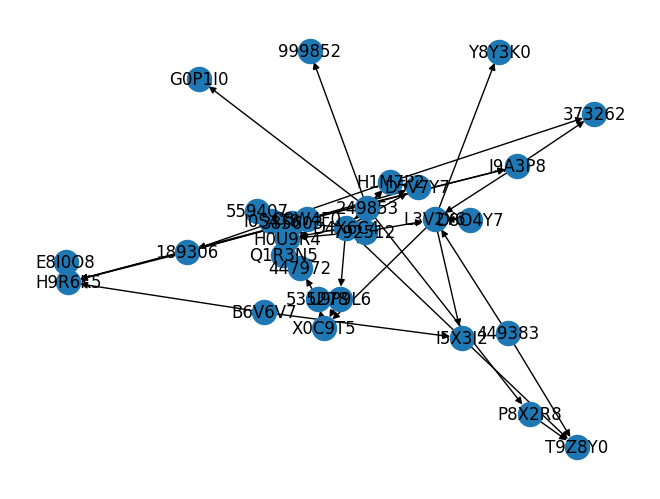

In [16]:
nx.draw(G, with_labels=True)

### 3.3 Some statistics

In [17]:
print("Number of nodes: {}".format(G.number_of_nodes()))
print("Number of edges: {}".format(G.number_of_edges()))

Number of nodes: 30
Number of edges: 47


In [18]:
limit = 5
for index, edge in enumerate(G.edges(data=True)):
    if index == limit:
        break
    print(edge)

('B6V6V7', 'H9R6K5', {'source': 'signor', 'Relationship ID': nan, 'label': 'interacts_with'})
('B6V6V7', 'I5X3I2', {'method': 'Lorem ipsum pblfc', 'Relationship ID': nan, 'label': 'interacts_with'})
('H9R6K5', 'E8I0O8', {'Relationship ID': 'intact277910', 'label': 'interacts_with'})
('I5X3I2', 'D4X6C4', {'source': 'intact', 'method': 'Lorem ipsum iiozd', 'Relationship ID': nan, 'label': 'interacts_with'})
('I5X3I2', 'T9Z8Y0', {'method': 'Lorem ipsum gconp', 'Relationship ID': 'intact994853', 'label': 'interacts_with'})


In [19]:
limit = 5
for index, node in enumerate(G.nodes(data=True)):
    if index == limit:
        break
    print(node)

('B6V6V7', {'sequence': 'CGLGLSMRFLMVGVQNWFWYGTRVPDVAYIDWHEYQHQPRVLMQNGN', 'description': 'Lorem ipsum kxujk', 'taxon': '4800', 'label': 'uniprot_isoform'})
('H9R6K5', {'sequence': 'CEDNSRWWHWPVKIAHININCSKACCENTSLATLTARSTLC', 'description': 'Lorem ipsum fdrbm', 'taxon': '7576', 'mass': 9671, 'label': 'uniprot_isoform'})
('I5X3I2', {'sequence': 'WSAAEAGGAELALDFWLVASRKKYGMLQVT', 'description': 'Lorem ipsum ddbvb', 'taxon': '4186', 'label': 'uniprot_isoform'})
('385603', {'sequence': 'EHYTERRSMRSTGQDKTSNPYLFFHITRFKRCPANQVKPWFMVLHKYEW', 'description': 'Lorem ipsum ufuuy', 'taxon': '9606', 'label': 'entrez_protein'})
('I9A3P8', {'sequence': 'YMSEGKWSIWIINMMLMHAQNLHVALIIVVY', 'description': 'Lorem ipsum dbhcg', 'taxon': '1230', 'mass': 6364, 'label': 'uniprot_protein'})
